In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback

from time import perf_counter
import functools

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10205935792302863653
xla_global_id: -1
]


'2.16.1'

In [3]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [4]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_18804\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [5]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [6]:
df['Stressed'] = df[stresses].any(axis=1)

In [7]:
def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [8]:
fuzzy_win = 5
fuzzy_dx_kernel = np.hstack((np.ones(fuzzy_win) * -1/fuzzy_win, np.ones(fuzzy_win)/fuzzy_win))

def fuzzy_dx(arr):
    return np.apply_along_axis(lambda x: np.convolve(x, fuzzy_dx_kernel, mode='valid'), arr=arr, axis=1)

# fuzzy_dx3 = fuzzy_dx(fuzzy_dx(fuzzy_dx(df[spec_cols].values)))

In [9]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

In [10]:
blur_factor = 4

# x = drop_res(fuzzy_dx3, blur_factor=blur_factor)
x = df[spec_cols].values
y = df['Stressed']

x /= x.max()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [11]:
@functools.cache
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

model = Sequential([
    Input(shape=(x_train.shape[1],1)),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    AveragePooling1D(blur_factor),
    Conv1D(20, 20, kernel_regularizer=L2(.001), name='conv1'),
    MaxPooling1D(2),
    Dropout(.02),
    Flatten(),
    Dense(40, kernel_regularizer=L2(.001)),
    Dropout(.02),
    Dense(30, kernel_regularizer=L2(.001)),
    Dropout(.02),
    Dense(10, kernel_regularizer=L2(.001)),
    Dropout(.02),
    Dense(1)
])

model.compile(optimizer=Nadam(1e-3, beta_1=.6, beta_2=.85), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
weights = {}
class GradientNormCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights[epoch] = [
            layer.trainable_weights[0].numpy() if layer.trainable_weights else np.array([0])
            for layer in self.model.layers 
        ]

class FreezeCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 75:
            self.model.get_layer(name='conv1').trainable = False

def drop_lr(epochs, lr):
    if epochs < 50:
        return 1e-3
    elif epochs < 150:
        return 1e-4
    else:
        return 1e-5
        

In [13]:
start = perf_counter()

history = model.fit(
    cnn_reshape(x_train),
    y_train,
    epochs=150,
    validation_data=(cnn_reshape(x_val), y_val),
    batch_size=100,
    callbacks = [GradientNormCallback(), LearningRateScheduler(drop_lr), FreezeCallback()]
)

print(perf_counter() - start)

Epoch 1/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5444 - loss: 1.1524 - val_accuracy: 0.6198 - val_loss: 1.1763 - learning_rate: 0.0010
Epoch 2/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6363 - loss: 0.7297 - val_accuracy: 0.6708 - val_loss: 0.6575 - learning_rate: 0.0010
Epoch 3/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7359 - loss: 0.6376 - val_accuracy: 0.7633 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 4/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7434 - loss: 0.6193 - val_accuracy: 0.7403 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 5/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7596 - loss: 0.5990 - val_accuracy: 0.6524 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 6/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7555 - loss: 0.6058 - val_accuracy: 0.6853 - val_loss: 0.6344 - learning_rate: 0.0010
Epoch 7/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7486 - loss: 0.

In [14]:
weights_diff = np.array([
    [np.linalg.norm(weights[j+1][i] - weights[j][i])/np.linalg.norm(weights[j][i]) for i in range(len(weights[0]))]
    for j in range(len(weights)-1)
])

C:\Users\amitt\AppData\Local\Temp\ipykernel_18804\3812862313.py:2: RuntimeWarning: invalid value encountered in scalar divide
  [np.linalg.norm(weights[j+1][i] - weights[j][i])/np.linalg.norm(weights[j][i]) for i in range(len(weights[0]))]


Text(0.5, 1.0, 'CNN Accuracy over Training')

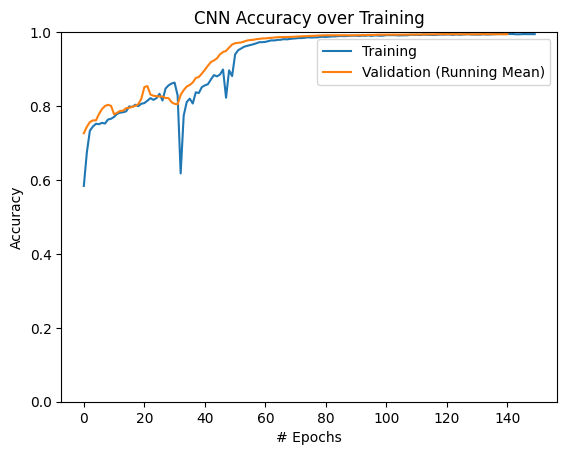

In [15]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['accuracy'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_accuracy']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim((0, 1))
ax.set_title('CNN Accuracy over Training')

Text(0.5, 1.0, 'Change in Layer Weights over Training')

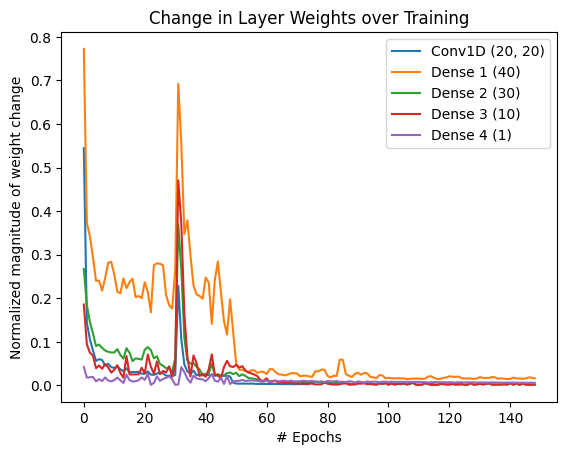

In [16]:
layer_diff = weights_diff[:,[4,8,10,12,14]]
fig, ax = plt.subplots()
ax.plot(layer_diff[:75,0], label='Conv1D (20, 20)')
ax.plot(layer_diff[:,1], label='Dense 1 (40)')
ax.plot(layer_diff[:,2], label='Dense 2 (30)')
ax.plot(layer_diff[:,3], label='Dense 3 (10)')
ax.plot(layer_diff[:,4], label='Dense 4 (1)')
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Normalized magnitude of weight change')
ax.set_title('Change in Layer Weights over Training')

In [17]:
# Validation Accuracy

y_pred = model.predict(cnn_reshape(x_val))
print(((y_pred > y_pred.mean()).flatten() == y_val).mean())
np.unique((y_pred > y_pred.mean()).flatten() == y_val, return_counts=True)

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0.9934488588334742


(array([False,  True]), array([  31, 4701], dtype=int64))

In [18]:
model.layers[4]

<Conv1D name=conv1, built=True>

## Grad-CAM

In [19]:
model.get_layer(index=-1).output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_15>

In [20]:
# def heatmap(x):
#     grad_model = Model(
#         model.inputs,
#         [model.get_layer(name='conv1').output, model.get_layer(index=-1).output]
#     )
    
#     with tf.GradientTape() as tape:
#         output, preds = 

In [21]:
# grad_model = Model(
#     model.inputs,
#     [model.get_layer(name='conv1').output, model.get_layer(index=-1).output]
# )

# with tf.GradientTape() as tape:
#     print(grad_model(x))

In [22]:
x

array([[0.17055194, 0.1755228 , 0.16198149, ..., 0.14004114, 0.13969832,
        0.1393555 ],
       [0.17055194, 0.1755228 , 0.16198149, ..., 0.14004114, 0.13969832,
        0.1393555 ],
       [0.17055194, 0.1755228 , 0.16198149, ..., 0.14004114, 0.13969832,
        0.1393555 ],
       ...,
       [0.17243744, 0.17466575, 0.16249571, ..., 0.1145012 , 0.11278711,
        0.11124443],
       [0.17243744, 0.17466575, 0.16249571, ..., 0.1145012 , 0.11278711,
        0.11124443],
       [0.17243744, 0.17466575, 0.16249571, ..., 0.1145012 , 0.11278711,
        0.11124443]])